# Extra plots of probability

Here we'll compare with some more data points. 

---

---
## Notebook admin

In [1]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

---

## Extrapolation errors

The combined nLVO and LVO probability distribution at time zero is calculated using a data point from Emberson et al. 2014, the value of odds ratio for mRS$\leq$1 at a time of 1 hr. This odds ratio has a value of 1.9 as read off the line in Figure 1. 

However, also plotted in that Figure 1 are two more lines marking the confidence interval (CI) of the odds ratio line. These have low and high values of 1.4 and 2.6 respectively. We can use these two extra values to draw an error estimate on the probability with time plot.

To find the error, we'll calculate three sets of probability lines using the three sets of odds ratio, and say that the true answer is bounded by the three lines.

### Step 1: Calculate constants a, b, A

Import the functions we'll need:

In [4]:
from outcome_utilities.probs_with_time        import find_mrs_constants
from outcome_utilities.scale_dist             import scale_dist
from outcome_utilities.extrapolate_odds_ratio import extrapolate_odds_ratio

We'll import the probability distributions from file. 

In [5]:
from outcome_utilities.mRS_datasets import (dict_pre_stroke,
    dict_t0_treatment_nlvo_lvo, dict_no_treatment_nlvo_lvo )

In [6]:
mrs_prob_dist_no_treatment = dict_no_treatment_nlvo_lvo['dist']
mrs_prob_bins_no_treatment = dict_no_treatment_nlvo_lvo['bins']
mrs_prob_bins_pre_stroke   = dict_pre_stroke['bins']

Define the reference probability at the no-effect time, $P(\mathrm{mRS}\leq1, t=t_\mathrm{ne})$, and the no effect time $t_\mathrm{ne}$.

In [7]:
p_mRSleq1_tne = mrs_prob_bins_no_treatment[1]
t_ne = 6.3 * 60 # minutes

For the three odds ratios, calculate the straight-line constants $a$, $b$, and $A$.

In [8]:
list_dists     = []
list_bins      = []
list_constants = []

for i,OR in enumerate([1.4, 1.9, 2.6]):
    OR_0, p_mRSleq1_t0, a_0, b_0 = extrapolate_odds_ratio(
        t_1=60,   OR_1=OR,                       # t=1hr data
        t_2=t_ne, OR_2=1,   p_2=p_mRSleq1_tne,   # t=t_ne data 
        t_e=0 )                                  # Extrapolate to this time.
    
    dist, bins = (
        scale_dist(mrs_prob_bins_pre_stroke, p_mRSleq1_t0, mRS_ref=1))
    
    list_dists.append(dist)
    list_bins.append(bins)
    
    # Find straight line constants a,b,A
    a,b,A = find_mrs_constants(bins, mrs_prob_bins_no_treatment, t_ne)
    list_constants.append([a,b,A])

### Step 2: Plot P as function of time 

n.b. we cannot find the errors for mRS=5 in this way, so we've just plotted the base line.

In [9]:
t = np.arange(0,6.3*60)

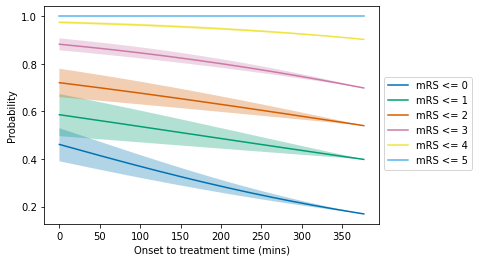

In [10]:
# For each mRS:
for i in range(5):
    # Store the three probability lines in probs:
    probs = []
    for j in range(3):
        # Pull out the a, b, A for this line:
        a = list_constants[j][0][i]
        b = list_constants[j][1][i]
        A = list_constants[j][2][i]
        # Calculate probability with time:
        p_i = np.exp(A + b*t) / (1+np.exp(A + b*t))
        probs.append(p_i)
    
    # Plot the middle line as usual:
    plt.plot(t, probs[1], '-', label = f'mRS <= {i}')
    # Fill between the low and high lines for the error interval:
    plt.fill_between(t, probs[0], probs[2], alpha=0.3)

# Plot mRS<=5 separately - it's 1 at all times.
plt.plot(t, [1.0 for x in t], '-', label = 'mRS <= 5')

plt.legend(loc='best',bbox_to_anchor=[1.0,0.5,0.2,0.2])
plt.ylabel('Probability')
plt.xlabel('Onset to treatment time (mins)')
plt.show()

---

## Thrombectomy: Compare with treated 'intervention' population

There are some data available that are independent of our calculated probability lines and so are worth a comparison. These are data that show the mRS of a patient population treated at a time of 285 minutes, over halfway to the no-effect-time for thrombectomy. The values are given in Figure 1B of Goyal et al. 2016.

First we'll set up the probability lines as usual. 

Import the data: the pre-stroke data from SAMueL-1, and the populations treated with thrombectomy at times zero and the no-effect-time.

In [16]:
from outcome_utilities.mRS_datasets import (dict_pre_stroke,
    dict_t0_treatment_lvo_ect, dict_no_treatment_lvo_ect)

In [17]:
mrs_prob_bins_no_treatment = dict_no_treatment_lvo_ect['bins']
mrs_prob_bins_t0_treatment = dict_t0_treatment_lvo_ect['bins']

Define the no-effect time and find the straight-line constants a, b, and A:

In [18]:
t_ne = 8*60 # minutes
t = np.arange(0,t_ne)

In [19]:
a_ect, b_ect, A_ect = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                                         mrs_prob_bins_no_treatment, t_ne)

Define the treated 'intervention' population:

In [11]:
dist_treated = np.array([0.100, 0.169, 0.191, 0.169, 0.156, 0.062])#, 0.153])

In [12]:
# Cumulative probability of treated population:    
bins_treated = np.cumsum(dist_treated)
# Normalise because excluding mRS=6:
bins_treated = bins_treated / bins_treated[-1]

Calculate the margin of error associated with each point, i.e. the error bars on the y-axis:

In [13]:
# Margin of error calculation:
z    = 1.96
n    = 633
errs = []

In [14]:
for i,p in enumerate(dist_treated):
    err = p * z * np.sqrt(p*(1.0-p)/n)    
    errs.append(p*err)

    if n*p<10.0 or n*(1-p)<10.0:
        # Print the n*p and n*(1-p) values to check they are above 10.0,
        # else this error method is invalid.
        print('mRS \t n*p \t n*(1-p)')
        print(i, '\t', round(n*p,1), '\t', round(n*(1-p),1))

The errorbars along the x-axis are given in the paper (Table 1, "onset to reperfusion").

In [15]:
xerr = np.array([[285-210],[362-285]])

### Plot the data:

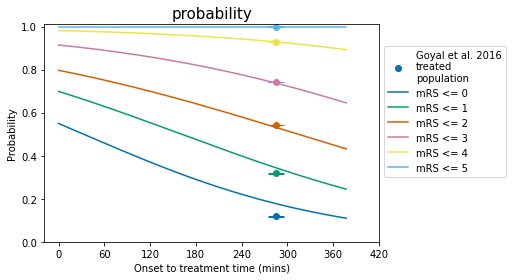

In [32]:
# Scatter the treated 'intervention' population:
cpt_label = 'Goyal et al. 2016'+'\n'+'treated'+'\n'+'population'
for i,p in enumerate(bins_treated):
    if i>0:
        cpt_label = None
    s = plt.scatter(285, p, label=cpt_label)
    plt.errorbar(285, p, yerr=errs[i], 
                 # xerr=xerr, 
                 color=s.get_facecolors(), capsize=8) 

# Draw probability lines as usual:
for i,A_i in enumerate(A_ect):
    p_i = 1.0/(1.0 + np.exp(-b_ect[i]*(t+A_i/b_ect[i])) )
    plt.plot(t, p_i, label = f'mRS <= {i}')

# Manually add the mRS<5 line:
plt.plot(t, [1.0 for x in t], label = 'mRS <= 5')

# Figure setup:
plt.ylabel('Probability')
plt.xlabel('Onset to treatment time (mins)')
plt.xticks(np.arange(0,t_ne+60,60))
plt.ylim(0,1.01)
plt.legend(loc='center left', bbox_to_anchor=[1.0,0.5,0.2,0.2])
plt.title('probability', fontsize=15)
plt.show()

---

## Thrombolysis: Compare with treated 'intervention' population

# ARE THESE THE WRONG DATA?

We can do a similar comparison for thrombolysis using the treated population given in Lees et al. 2010. 

Create the probability lines as usual. Import the data from file:

In [23]:
from outcome_utilities.mRS_datasets import (dict_pre_stroke,
    dict_t0_treatment_nlvo_lvo, dict_no_treatment_nlvo_lvo)

In [24]:
mrs_prob_bins_no_treatment = dict_no_treatment_nlvo_lvo['bins']
mrs_prob_bins_t0_treatment = dict_t0_treatment_nlvo_lvo['bins']

Set up the time of no effect, and find the straight-line constants a, b, and A:

In [25]:
t_ne = 6.3*60 # minutes
t = np.arange(0,t_ne)

In [26]:
a_oly, b_oly, A_oly = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                                         mrs_prob_bins_no_treatment, t_ne)

Define the treated population. 
These values are measured from the image using a ruler on Powerpoint and so the number of patients are not integers. The probabilities will be close enough. 

In [21]:
# Numbers of patients in the four bars: 161, 303, 809, 576.
n_0 = np.array([ 36.10661765,  31.10825163,  12.89052288,  21.44035948,  21.76919935,   6.77410131,  30.91094771])
n_1 = np.array([ 52.23284314,  74.01715686,  22.27941176,  40.10294118,  35.77083333,  25.12622549,  53.47058824])
n_2 = np.array([190.68341503, 171.84640523, 105.75163399,  83.94035948,  95.17647059,  73.69566993,  87.90604575])
n_3 = np.array([103.29411765, 113.17647059,  67.76470588,  64.94117647,  85.88235294,  56.,          84.94117647])


# # Combine the four datasets and create probability distribution:
# n_t_oly = np.sum([n_0,n_1,n_2,n_3],axis=0)
# # Remove mRS=6 with [:-1]:
# dist_t_oly = n_t_oly[:-1] / np.sum(n_t_oly[:-1])

# # Create cumulative probability:
# bins_t_oly = np.cumsum(np.concatenate(([0.0],dist_t_oly)))

Calculate margin of error associated with the data:

In [ ]:
# Number of patients from above:
ns = [n_0,n_1,n_2,n_3]
# Average treatment time for each population:
nts = [45.0,135.0,225.0,315]
# Store binned prob dists and errors in these lists:
bns = []
ens = []

In [22]:
for j,n in enumerate(ns):
    # Convert number distribution to probability:
    # Remove mRS=6 with [:-1]:
    d_n = n[:-1] / np.sum(n[:-1])
    
    
    # Margin of error calculation:
    z = 1.96
    n = np.sum(n[:-1])
    errs = []
    for i,p in enumerate(d_n):
        err = p * z * np.sqrt(p*(1.0-p)/n)
        errs.append(p*err)
        if n*p<10.0 or n*(1-p)<10.0:
            # Print the n*p and n*(1-p) values to check they are above 10.0,
            # else this error method is invalid.
            print('time \t mRS \t n*p \t n*(1-p)')
            print(nts[j], '\t', i, '\t', round(n*p,1), '\t', round(n*(1-p),1))
    ens.append(errs)

    # Create cumulative probability:
    b_n = np.cumsum(d_n)
    bns.append(b_n)

# Transpose for easier plotting:
bns = np.transpose(np.array(bns))
ens = np.transpose(np.array(ens))

time 	 mRS 	 n*p 	 n*(1-p)
45.0 	 5 	 6.8 	 123.3


### Plot the data:

Plot data as scatter with errorbars. The x-errors are a flat $\pm$45 minutes.

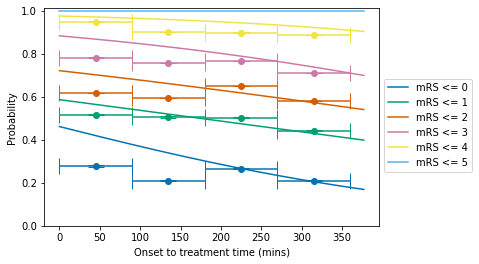

In [33]:
t = np.arange(0,t_ne)
    
for i,A_i in enumerate(A_oly):
    # Plot the probability lines:
    p_i = np.exp(A_i + b_oly[i]*t)/(1+np.exp(A_i + b_oly[i]*t))
    l, = plt.plot(t, p_i, label = f'mRS <= {i}')
    
    # Scatter the treated patient population at the given times:
    plt.errorbar(nts, bns[i,:], yerr=ens[i,:], xerr=45, 
                 fmt='o', color=l.get_color(), capsize=8)
     

# Manually add the mRS<5 line:
plt.plot(t, [1.0 for x in t], label = 'mRS <= 5')

# Figure setup:
plt.ylim(0,1.01)
plt.legend(loc='upper left', bbox_to_anchor=[1.0,0.5,0.2,0.2])
plt.ylabel('Probability')
plt.xlabel('Onset to treatment time (mins)')
plt.show()

---

## References

Goyal M, Menon BK, van Zwam WH, et al. _Endovascular thrombectomy after large-vessel ischaemic stroke: a meta-analysis of individual patient data from five randomised trials._ The Lancet 2016;387:1723-1731. doi:10.1016/S0140-6736(16)00163-X

Lees KR, Bluhmki E, von Kummer R, et al. _Time to treatment with intravenous alteplase and outcome in stroke: an updated pooled analysis of ECASS, ATLANTIS, NINDS, and EPITHET trials_. The Lancet 2010;375:1695-703. doi:10.1016/S0140-6736(10)60491-6

SAMueL-1 data